In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_GM12878", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_GM12878", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = matplotlib.colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_GM12878": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_GM12878": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

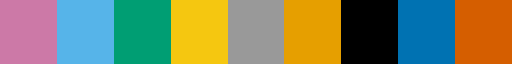

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_gm12878 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_GM12878.tsv", sep="\t")

In [7]:
chip_atlas_gm12878.head()

,tf,Target_genes
0,ARID3A,SMARCD2
1,ARID3A,INTS5
2,ARID3A,LETM2
3,ARID3A,WDR74
4,ARID3A,KDM3A


In [8]:
gm12878 = pd.read_table("../data/regulons/GM12878_regulon.tsv", sep="\t")

gm12878 = gm12878.loc[gm12878.is_method_2 & gm12878.is_atac, ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
gm12878 = gm12878.loc[gm12878.tf.isin(collectri.source) & gm12878.tf.isin(chip_atlas_gm12878.tf)]
gm12878.shape

(550280, 2)

In [9]:
chip_atlas_gm12878 = chip_atlas_gm12878.loc[chip_atlas_gm12878.tf.isin(gm12878.tf)]
chip_atlas_gm12878.shape

(1576755, 2)

In [10]:
collectri = collectri[collectri.source.isin(gm12878.tf)]

### Prepare cosmic

In [11]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# AML integrated dataset

### C6 vs other leukemic cells

In [12]:
data = pd.read_csv("../data/case_study/c6_vs_other_leukemic_cells_aml_dataset.csv", sep=";", index_col=0)
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Takao & Kentsis LRC,Metadata: Velten
Gene,,,,,,,,
AREG,7,0,"2,3179424781",1,44,7,NaN,Other
FOS,7,0,"2,0089384569",1,42,7,NaN,AP1 factors
FTH1,7,0,"1,2502755149",1,60,7,NaN,Erythromyeloid priming
SLC40A1,7,0,"1,2451559941",1,47,7,1.0,Erythromyeloid priming
CD69,6,0,"1,0858648734",1,39,6,NaN,Other
...,...,...,...,...,...,...,...,...
YPEL3,1,1,"0,0845519869",0,15,0,NaN,Other
YWHAZ,1,1,"0,0008226982",0,7,0,NaN,Erythromyeloid priming
ZEB2,2,2,"-0,1924227130",1,26,0,-1.0,Other


In [13]:
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = - de_genes["Mean log2 Fold Change"]
#de_genes = de_genes[de_genes["Mean log2 Fold Change"].abs() > 1]

In [14]:
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
AREG,2.317942,-2.317942
FOS,2.008938,-2.008938
FTH1,1.250276,-1.250276
SLC40A1,1.245156,-1.245156
CD69,1.085865,-1.085865
...,...,...
ZSCAN18,0.277256,-0.277256
ZSCAN26,0.920350,-0.920350
ZSWIM6,0.433205,-0.433205


In [15]:
#enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET")
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Leukemia, Myelocytic, Acute",446/1703,4.340686e-30,3.762073e-26,0,0,2.015400,136.260247,RB1;CDA;CHIC2;SPI1;TFRC;BACH1;GLS;GJA1;HOXA9;M...
1,DisGeNET,leukemia,491/1941,2.413857e-29,1.046045e-25,0,0,1.931294,127.260209,RB1;CDA;CHIC2;SPI1;RNH1;TFRC;EHMT1;SMC4;GLS;SM...
2,DisGeNET,Acute lymphocytic leukemia,265/907,4.159066e-25,1.201554e-21,0,0,2.286223,128.347040,RB1;IL1RN;SPI1;GFI1;JMJD1C;IKZF1;ACTB;GLS;LGAL...
3,DisGeNET,Precursor Cell Lymphoblastic Leukemia Lymphoma,192/618,1.124858e-21,2.437286e-18,0,0,2.467956,119.045868,RB1;IL1RN;CSF1;IRS1;MPG;GFI1;ATN1;F13A1;SLA;JM...
4,DisGeNET,"Liver Cirrhosis, Experimental",227/801,8.673278e-20,1.503426e-16,0,0,2.171344,95.303432,IFITM1;WIPF1;GMFG;ICAM2;ZDHHC2;GLS;SMC2;LGALS3...
...,...,...,...,...,...,...,...,...,...,...
8662,DisGeNET,Ragged-red muscle fibers,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,TYMP
8663,DisGeNET,Rat Adrenal Gland Pheochromocytoma,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,BCL2L1
8664,DisGeNET,Retinal Dystrophies,14/178,9.995380e-01,9.997687e-01,0,0,0.448258,0.000207,PEX16;HGSNAT;PRPS1;GRN;SUCNR1;TRAF3IP1;PRPF8;T...
8665,DisGeNET,Syndactyly,4/85,9.996806e-01,9.997960e-01,0,0,0.259783,0.000083,GJA1;NOG;LMNA;ZSWIM6


In [16]:
de_genes.drop("Mean log2 Fold Change", axis=1, inplace=True)

In [17]:
de_genes = de_genes.T

In [18]:
dc.check_corr(gm12878, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
3311,CEBPZ,ZNF217,-0.1042
3727,GABPA,ZNF217,-0.0854
3818,TBP,ZNF217,-0.0817
3831,SIN3A,ZNF217,-0.0812
4004,ELK1,ZNF217,-0.0742
...,...,...,...
4,HCFC1,ZNF143,0.5809
3,PML,SMAD5,0.5880
2,FOS,NFYA,0.6186
1,PAX5,SP1,0.6460


In [19]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
839,MYC,SREBF1,-0.0867
1095,MYC,SREBF2,-0.0696
1306,EBF1,SP1,-0.0563
1377,NRF1,STAT1,-0.0521
1424,MYC,RFX5,-0.0496
...,...,...,...
4,IRF3,IRF5,0.3704
3,IRF4,IRF5,0.3832
2,ARNT,NFATC3,0.3849
1,NFYA,NFYB,0.5330


In [20]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

gm12878

In [21]:
tf_acts_gm12878, tf_pvals_gm12878= dc.run_ulm(de_genes, gm12878, source='tf', target='gene_symbol', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [22]:
mask = tf_pvals_gm12878 < 0.01
active_tfs_gm12878 = tf_acts_gm12878.loc["leukemic", pd.DataFrame(tf_acts_gm12878 * mask).sum(axis=0) != 0].index.to_list()

In [23]:
tf_acts_gm12878.index = ["score"]
tf_pvals_gm12878.index = ["p_value"]
out_gm12878 = pd.merge(left=tf_acts_gm12878.T, right=tf_pvals_gm12878.T, left_index=True, right_index=True)
out_gm12878.to_csv("../data/3-tf_activity/aml_gm12878_activity_m2kb.tsv", sep="\t", index=False)

In [24]:
enr = gp.enrich(active_tfs_gm12878, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [25]:
enr = gp.enrich(active_tfs_gm12878, "DisGeNET")
enr.results["Network"] = "M2Kb_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [26]:
try:
    enr = gp.enrich(gene_list=active_tfs_gm12878, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_GM12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_GM12878"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [27]:
heat = pd.concat([tf_acts_gm12878.rename({"leukemic": "score"}), tf_pvals_gm12878.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_GM12878"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID3A,1.315126,0.188562,M2Kb_GM12878
ARNT,1.385618,0.165961,M2Kb_GM12878
ATF2,-0.586675,0.557463,M2Kb_GM12878
ATF3,0.613878,0.539340,M2Kb_GM12878
ATF7,0.914147,0.360709,M2Kb_GM12878
...,...,...,...
ZEB1,-0.328320,0.742692,M2Kb_GM12878
ZNF143,0.062292,0.950334,M2Kb_GM12878
ZNF217,0.606095,0.544495,M2Kb_GM12878
ZNF24,0.013348,0.989351,M2Kb_GM12878


CollecTri

In [28]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight=None)
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [29]:
mask_ctri = tf_pvals_ctri < 0.01
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

CREB1   -3.125075
HSF1    -2.961596
NFE2    -2.893968
NFIC    -2.653232
ELF1     2.671553
TCF7     2.791151
MYB      2.813285
RFX5     2.920896
EZH2     2.955058
SP1      3.195663
Name: leukemic, dtype: float32

In [30]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_gm12878_activity_collectri.tsv", sep="\t", index=False)

In [31]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [32]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [33]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [34]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID3A,1.315126,0.188562,M2Kb_GM12878
ARNT,1.385618,0.165961,M2Kb_GM12878
ATF2,-0.586675,0.557463,M2Kb_GM12878
ATF3,0.613878,0.539340,M2Kb_GM12878
ATF7,0.914147,0.360709,M2Kb_GM12878
...,...,...,...
USF2,0.027700,0.977903,CollecTri
YBX1,1.925811,0.054217,CollecTri
YY1,1.131990,0.257724,CollecTri
ZBED1,-0.299977,0.764214,CollecTri


chip_atlas_gm12878

In [35]:
tf_acts_chip_atlas_gm12878, tf_pvals_chip_atlas_gm12878 = dc.run_ulm(de_genes, chip_atlas_gm12878.drop_duplicates(), source='tf', target='Target_genes', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [36]:
mask_chip_atlas_gm12878 = tf_pvals_chip_atlas_gm12878 < 0.01

active_tfs_chip_atlas_gm12878 = tf_acts_chip_atlas_gm12878.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_gm12878 * mask_chip_atlas_gm12878).sum(axis=0) != 0].index.to_list()

In [37]:
tf_acts_chip_atlas_gm12878.index = ["score"]
tf_pvals_chip_atlas_gm12878.index = ["p_value"]
out_chip_atlas_gm12878 = pd.merge(left=tf_acts_chip_atlas_gm12878.T, right=tf_pvals_chip_atlas_gm12878.T, left_index=True, right_index=True)
out_chip_atlas_gm12878.to_csv("../data/3-tf_activity/aml_gm12878_activity_ca_gm12878.tsv", sep="\t", index=False)

In [38]:
active_tfs_chip_atlas_gm12878

['ARID3A', 'IKZF1', 'IKZF2', 'MTA2', 'SMAD1', 'TBP']

In [39]:
enr = gp.enrich(active_tfs_chip_atlas_gm12878, "OMIM_Expanded")
enr.results["Network"] = "CA_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_gm12878_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [40]:
enr = gp.enrich(active_tfs_chip_atlas_gm12878, "DisGeNET")
enr.results["Network"] = "CA_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_gm12878_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [41]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_gm12878, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_GM12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_gm12878_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_GM12878"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [42]:
heat = pd.concat([tf_acts_chip_atlas_gm12878.rename({"leukemic": "score"}), tf_pvals_chip_atlas_gm12878.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CA_GM12878"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID3A,1.315126,0.188562,M2Kb_GM12878
ARNT,1.385618,0.165961,M2Kb_GM12878
ATF2,-0.586675,0.557463,M2Kb_GM12878
ATF3,0.613878,0.539340,M2Kb_GM12878
ATF7,0.914147,0.360709,M2Kb_GM12878
...,...,...,...
ZEB1,-2.221846,0.026364,CA_GM12878
ZNF143,0.686264,0.492597,CA_GM12878
ZNF217,0.997209,0.318739,CA_GM12878
ZNF24,-0.073682,0.941268,CA_GM12878


Plotting results

In [43]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM12878": 8,
            "CA_GM12878": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[6], pal[7], pal[8]]

In [44]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,10.000000,10.000000,10.0,10.0,10.000000,10.000000,10.000000
mean,0.025843,0.040980,0.0,0.0,46.207724,228.169694,1.395718
std,0.014579,0.008358,0.0,0.0,22.418207,226.757110,0.089711
min,0.000359,0.033050,0.0,0.0,28.931686,94.246077,1.310610
25%,0.025821,0.033050,0.0,0.0,28.931686,94.246077,1.310610
50%,0.025821,0.040980,0.0,0.0,46.297674,169.290873,1.395718
75%,0.038483,0.048909,0.0,0.0,46.297674,169.290873,1.480825
max,0.038483,0.048909,0.0,0.0,102.561856,813.496677,1.480825


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_gm12878.svg


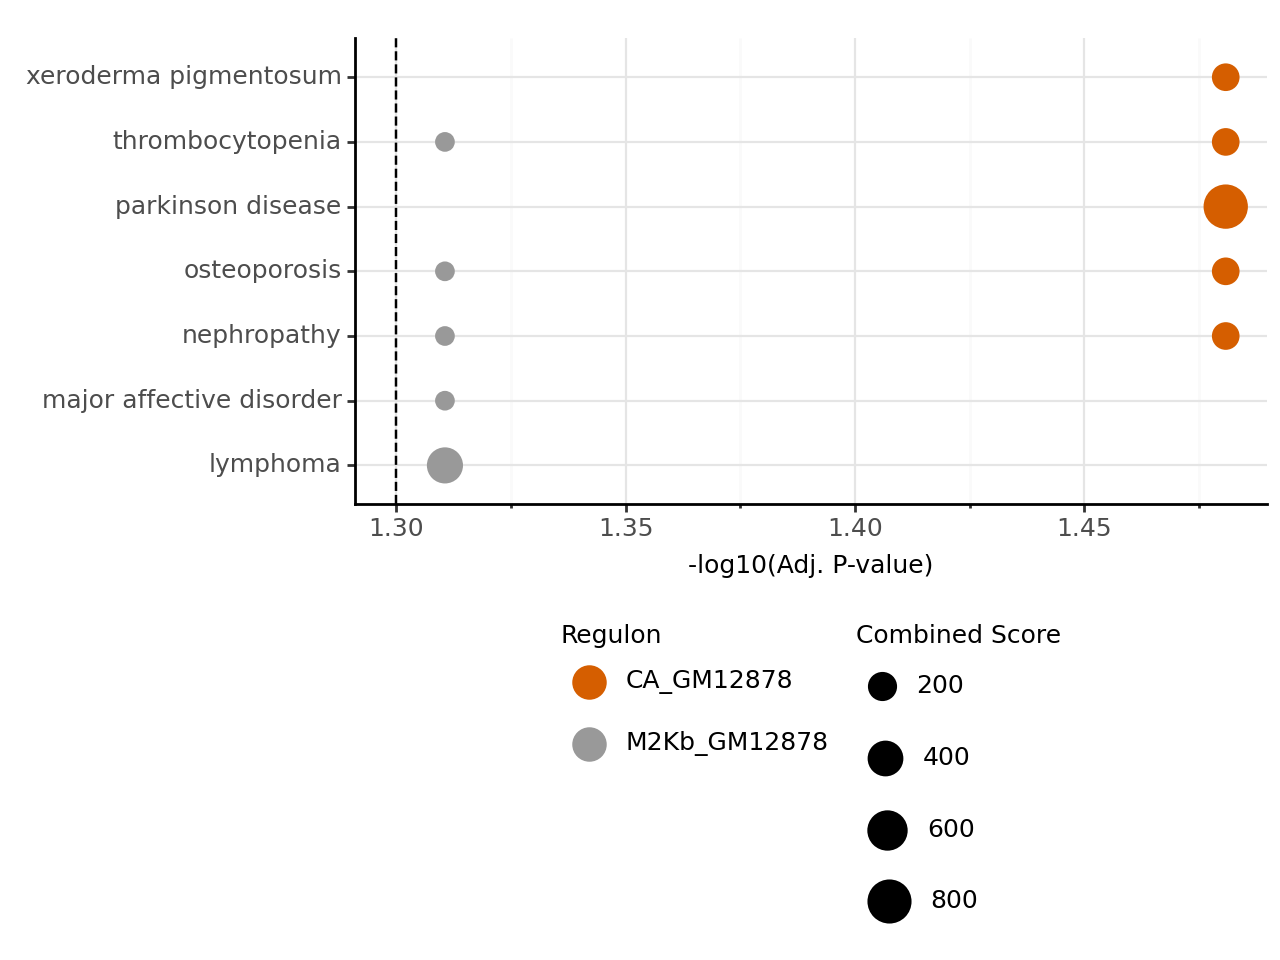

<Figure Size: (640 x 480)>

In [45]:
p = plot_enrich(aml_omim_enrich, [okabe[0], okabe[2]])
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_gm12878.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [46]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,15.000000,15.0,15.0,15.000000,15.000000,15.000000
mean,3.678177e-04,0.007926,0.0,0.0,80.877395,754.818860,2.628871
std,1.225323e-03,0.012018,0.0,0.0,74.864653,503.388847,0.759466
min,1.683400e-07,0.000121,0.0,0.0,25.249951,304.559604,1.346189
25%,3.023577e-06,0.000642,0.0,0.0,32.318751,343.057005,1.831874
50%,7.125743e-06,0.000929,0.0,0.0,44.524775,554.622861,3.032114
75%,1.214883e-04,0.014727,0.0,0.0,105.804657,1144.896351,3.197030
max,4.790942e-03,0.045062,0.0,0.0,266.386667,1795.688136,3.917084


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_gm12878.svg


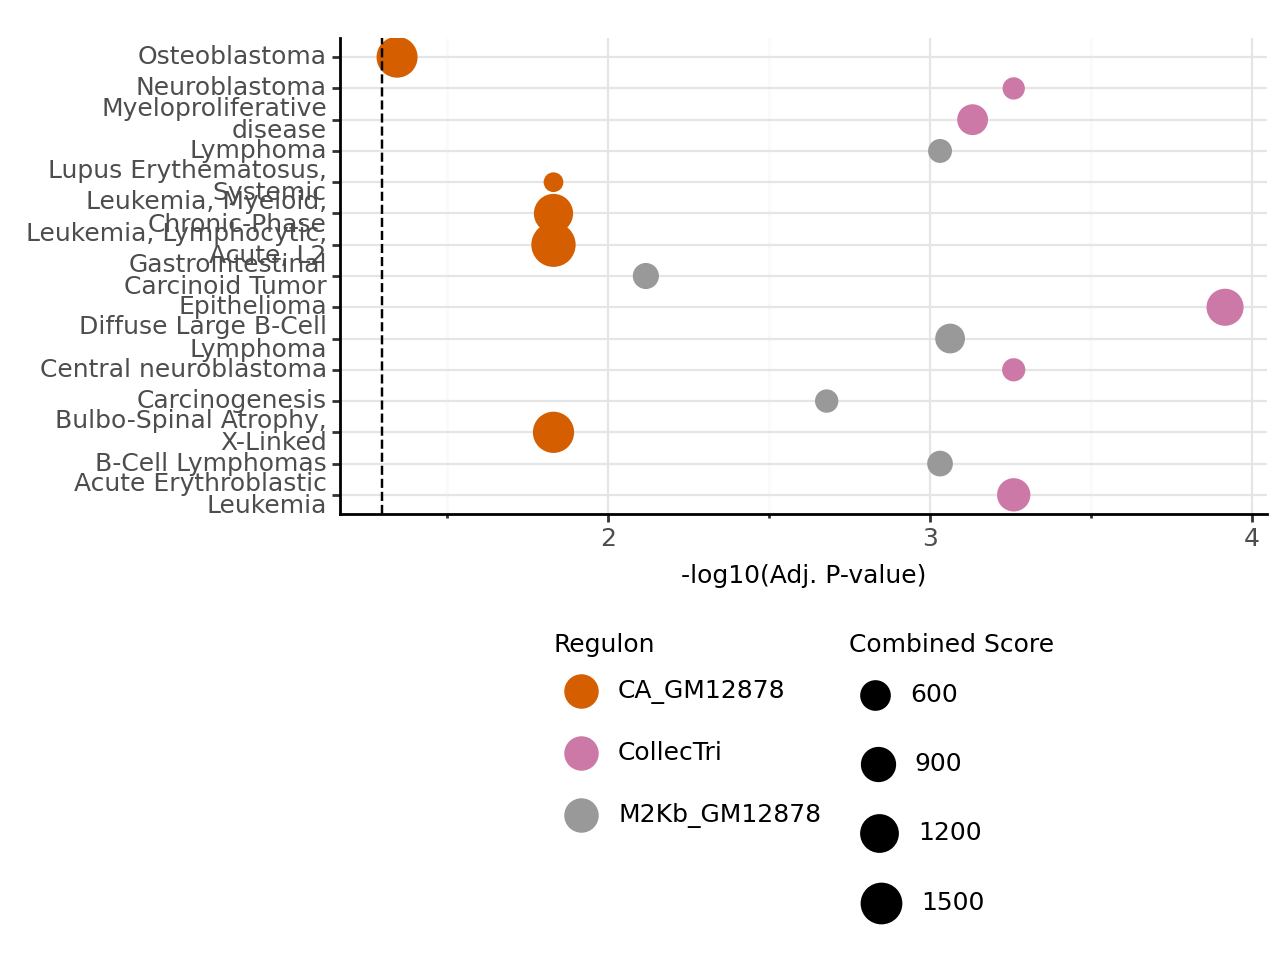

<Figure Size: (640 x 480)>

In [47]:
p = plot_enrich(aml_disreg_enrich, palette=okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_gm12878.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [48]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.021343,0.027660,111.548125,451.897683,1.585083
std,0.011544,0.010888,27.398936,157.843273,0.165338
min,0.009479,0.018927,68.660377,219.081042,1.385744
25%,0.014195,0.018927,106.114286,400.918551,1.431875
50%,0.018174,0.022913,107.914286,459.157776,1.646591
75%,0.025712,0.037579,122.952709,480.434792,1.722914
max,0.041139,0.041139,151.320000,704.956900,1.722914


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_gm12878.svg


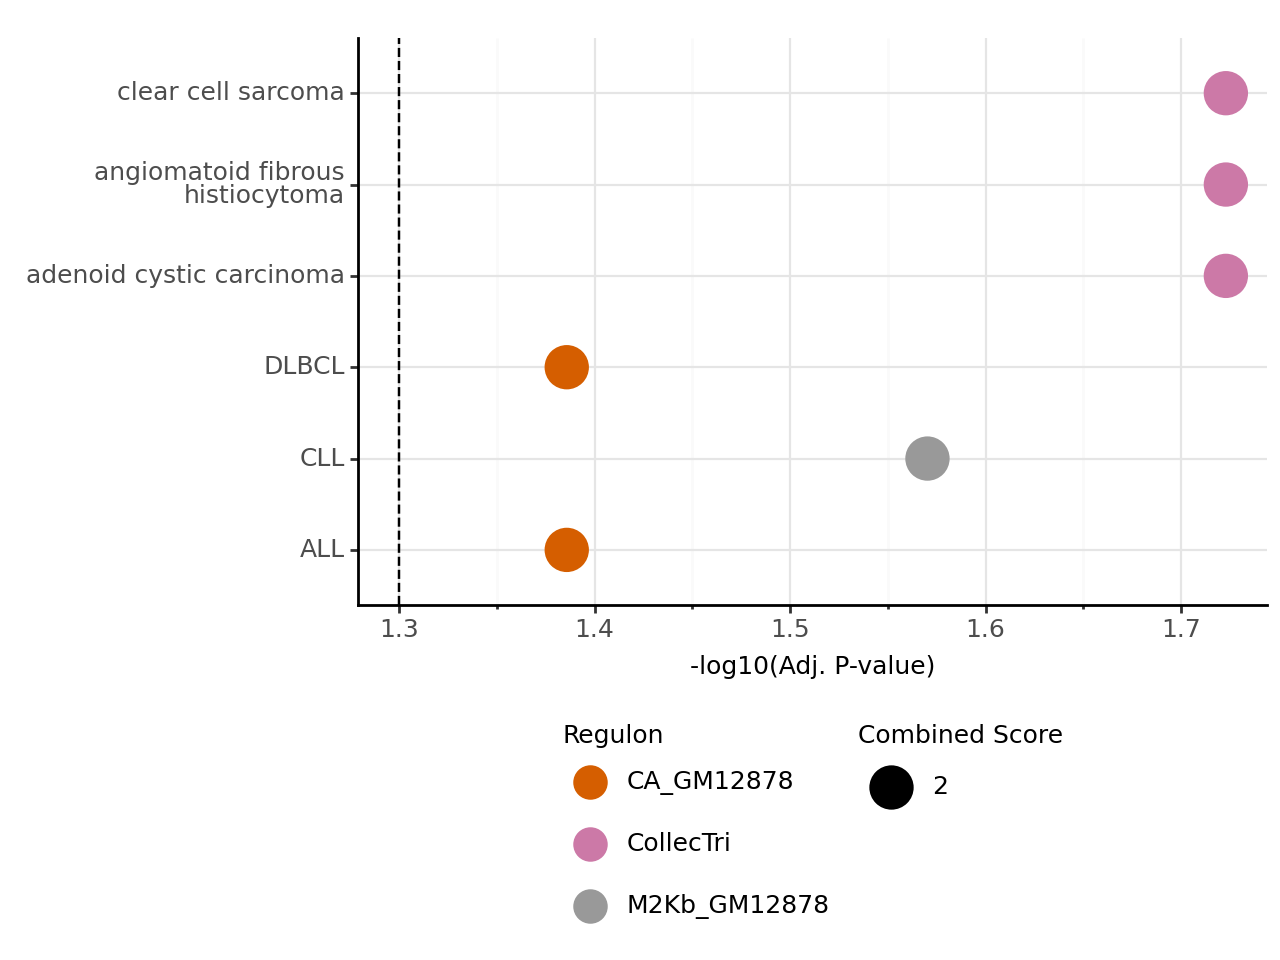

<Figure Size: (640 x 480)>

In [49]:
p = plot_enrich(aml_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_gm12878.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [50]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.021343,0.027660,111.548125,451.897683,1.585083
std,0.011544,0.010888,27.398936,157.843273,0.165338
min,0.009479,0.018927,68.660377,219.081042,1.385744
25%,0.014195,0.018927,106.114286,400.918551,1.431875
50%,0.018174,0.022913,107.914286,459.157776,1.646591
75%,0.025712,0.037579,122.952709,480.434792,1.722914
max,0.041139,0.041139,151.320000,704.956900,1.722914


In [51]:
megaheat.describe()

,score,p_value
count,307.000000,307.000000
mean,0.606857,0.380559
std,1.268893,0.307197
min,-3.125075,0.001361
25%,-0.119813,0.089846
50%,0.687213,0.339311
75%,1.457484,0.615716
max,3.205704,0.989351


In [52]:
megaheat.to_csv("../data/3-tf_activity/aml_gm12878_activity_estimates_hsc.tsv", sep="\t", index=False)

In [53]:
megaheat = megaheat[megaheat.p_value < 0.01].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [54]:
print(megaheat[megaheat.Network == "M2Kb_GM12878"].sort_values("score").to_string())

           score   p_value       Network      TF  log_p
MTA3    2.640706  0.008314  M2Kb_GM12878    MTA3    2.1
CEBPB   2.665163  0.007734  M2Kb_GM12878   CEBPB    2.1
SMAD5   2.691415  0.007152  M2Kb_GM12878   SMAD5    2.1
NFATC1  2.802299  0.005105  M2Kb_GM12878  NFATC1    2.3
ZBED1   2.814106  0.004921  M2Kb_GM12878   ZBED1    2.3
MED1    2.871798  0.004108  M2Kb_GM12878    MED1    2.4
TBP     2.980251  0.002902  M2Kb_GM12878     TBP    2.5
SMAD1   2.996291  0.002754  M2Kb_GM12878   SMAD1    2.6
BCL3    3.205704  0.001361  M2Kb_GM12878    BCL3    2.9


In [55]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

          score   p_value    Network     TF  log_p
CREB1 -3.125075  0.001794  CollecTri  CREB1    2.7
HSF1  -2.961596  0.003083  CollecTri   HSF1    2.5
NFE2  -2.893968  0.003830  CollecTri   NFE2    2.4
NFIC  -2.653232  0.008012  CollecTri   NFIC    2.1
ELF1   2.671553  0.007589  CollecTri   ELF1    2.1
TCF7   2.791151  0.005283  CollecTri   TCF7    2.3
MYB    2.813285  0.004934  CollecTri    MYB    2.3
RFX5   2.920896  0.003515  CollecTri   RFX5    2.5
EZH2   2.955058  0.003149  CollecTri   EZH2    2.5
SP1    3.195663  0.001409  CollecTri    SP1    2.9


In [56]:
megaheat

,score,p_value,Network,TF,log_p
CREB1,-3.125075,0.001794,CollecTri,CREB1,2.7
HSF1,-2.961596,0.003083,CollecTri,HSF1,2.5
NFE2,-2.893968,0.003830,CollecTri,NFE2,2.4
ARID3A,-2.797535,0.005180,CA_GM12878,ARID3A,2.3
NFIC,-2.653232,0.008012,CollecTri,NFIC,2.1
SMAD1,2.579247,0.009946,CA_GM12878,SMAD1,2.0
MTA3,2.640706,0.008314,M2Kb_GM12878,MTA3,2.1
CEBPB,2.665163,0.007734,M2Kb_GM12878,CEBPB,2.1
ELF1,2.671553,0.007589,CollecTri,ELF1,2.1
SMAD5,2.691415,0.007152,M2Kb_GM12878,SMAD5,2.1


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


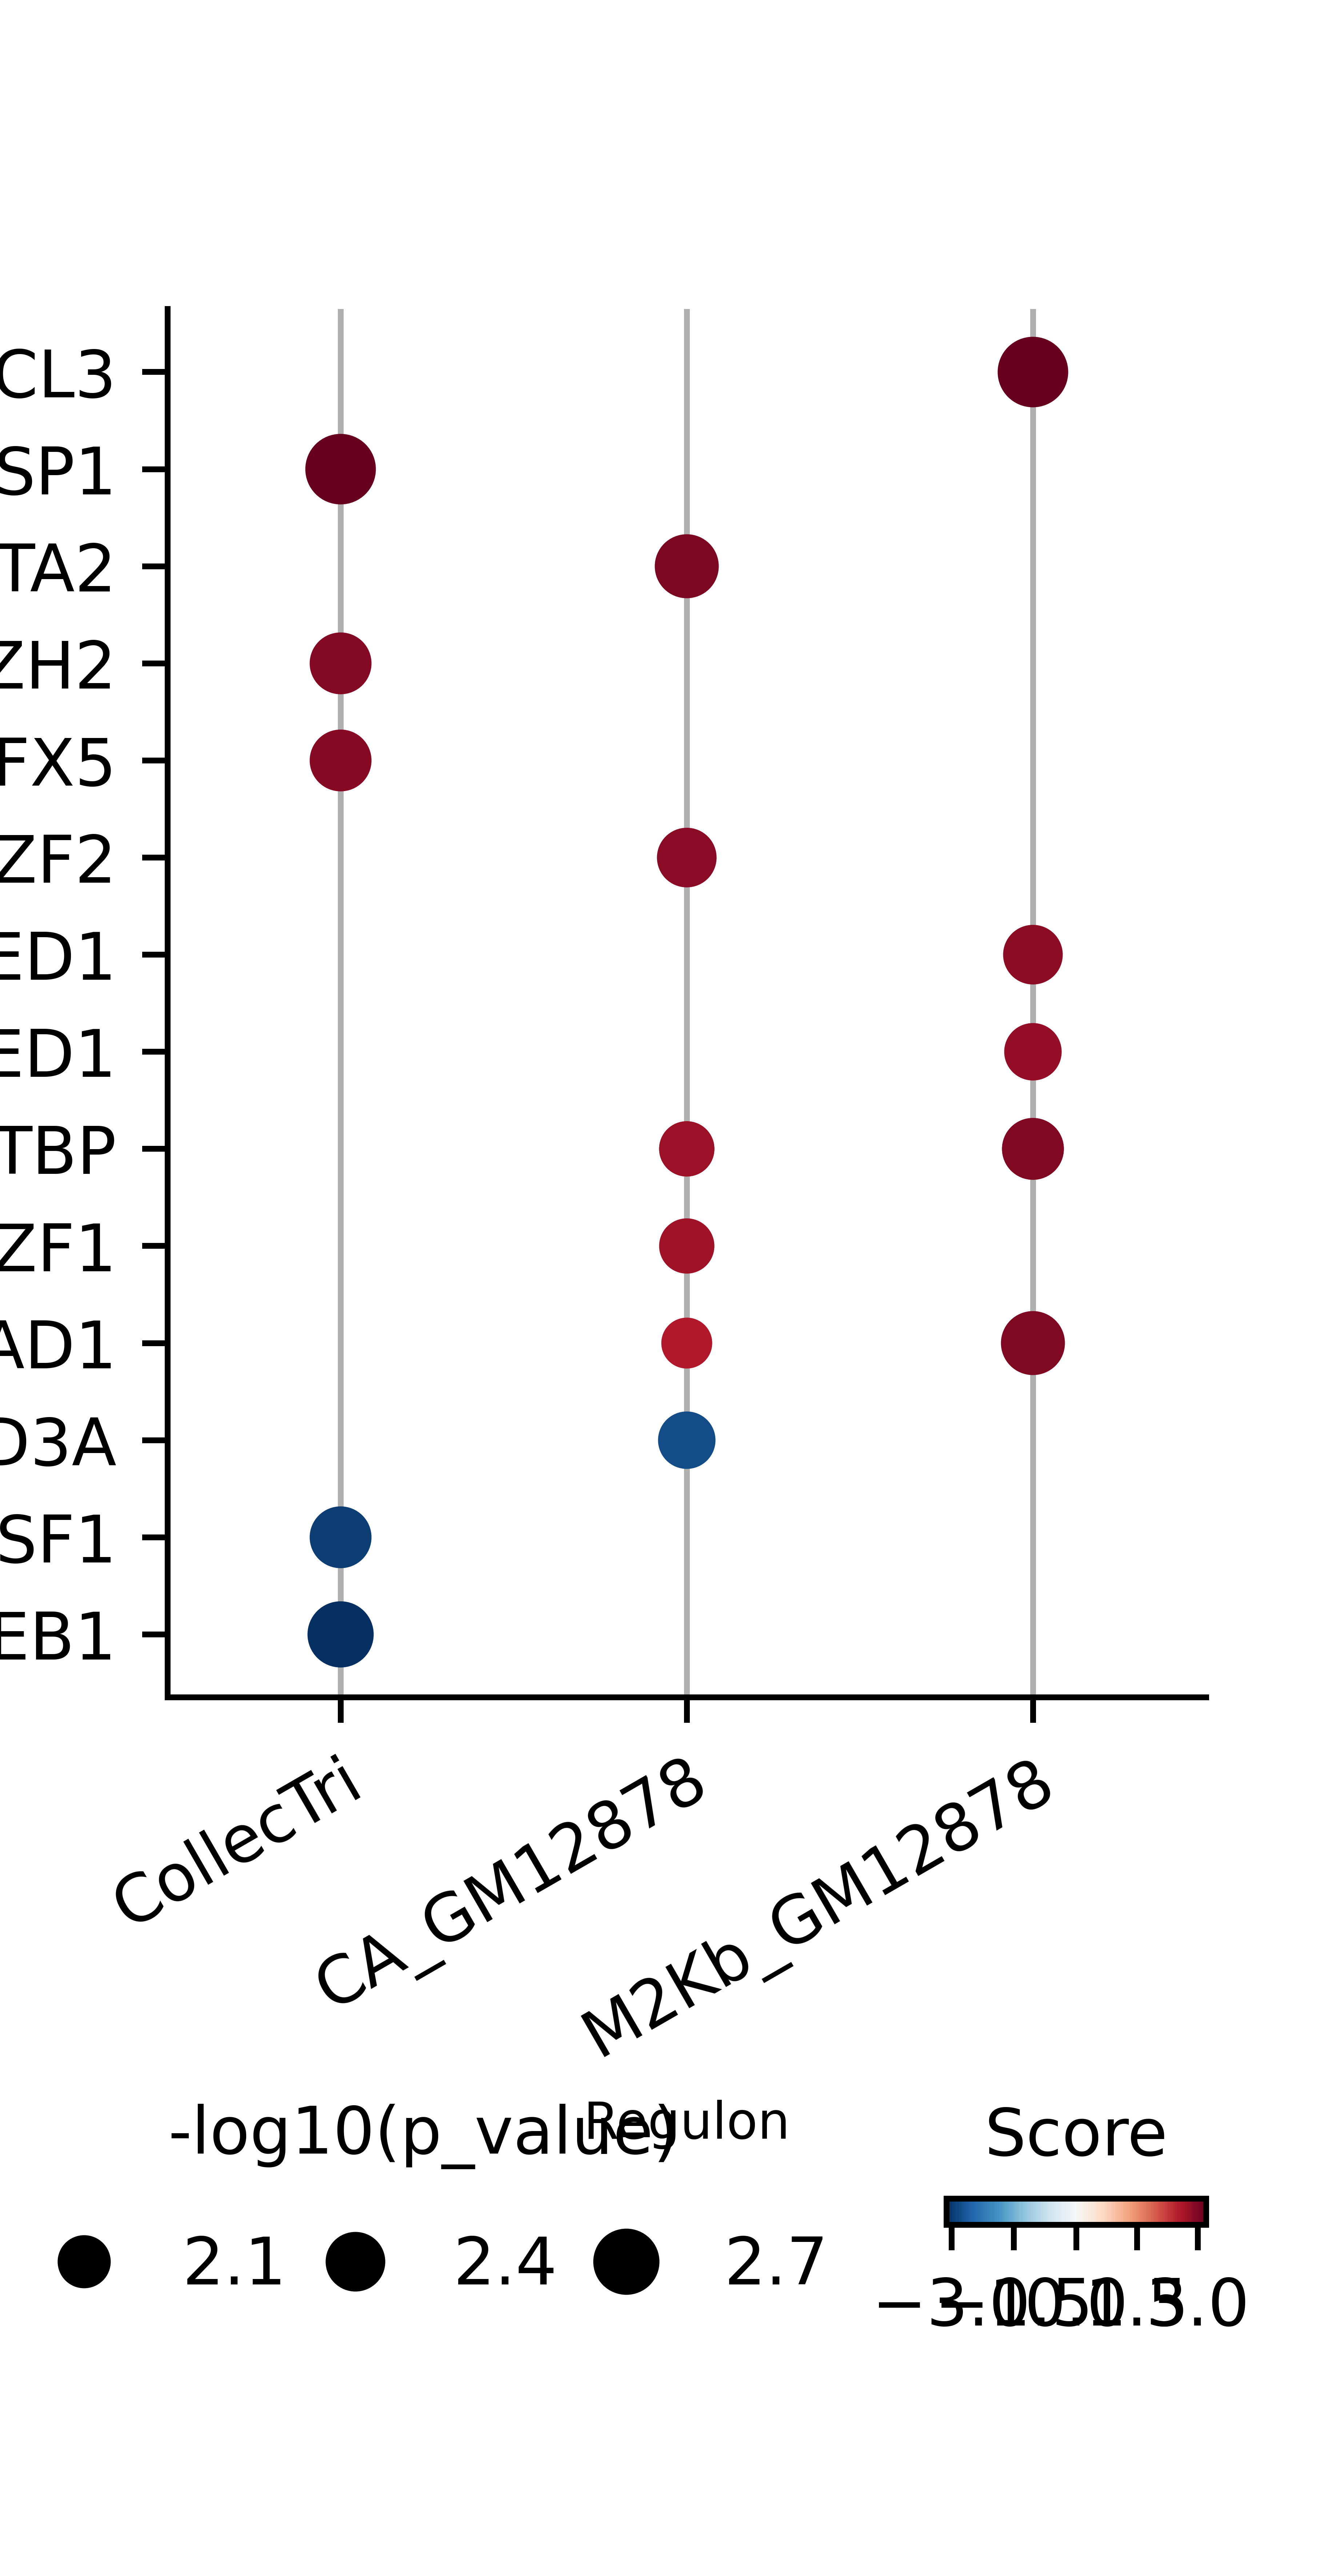

In [57]:
plt.close()
out = pd.DataFrame()
interesting_tf = ["GATA1", "GATA2", "KLF1", "SPI1"]
for net in ["CollecTri", "M2Kb_GM12878", "CA_GM12878"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out, scale=0.5)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_hsc_gm12878.svg", dpi=720, format="svg")
plt.show()

In [58]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_GM-12878"].index.to_list()))

In [59]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

CREB1, HSF1, NFE2, NFIC, ELF1, TCF7, MYB, RFX5, EZH2, SP1


In [60]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_hsc.tsv", sep="\t", index=False)

In [61]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_GM12878"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)